# Handling Missing Data

1. Mean/ Mode
2. KNN with top 15 features
3. KNN with all the features

In [1]:
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import spatial
from scipy.stats import mode
from sklearn.neighbors import KDTree
import sys
import time
from multiprocessing import Pool
from pathos.multiprocessing import ProcessingPool as Pool1

color = sns.color_palette()
%matplotlib inline

sys.setrecursionlimit(1000000)

Importing Data

In [2]:
df = pd.read_pickle("df_partial_filled_with_15.pkl")
n_rows,c_cols = df.shape
feature_type = ["disc","cont","disc","factor","factor","cont","disc","disc","factor","factor",
                "disc","factor","cont","cont","cont","cont","cont","cont","cont","factor",
                "factor","disc","disc","cont","factor","factor","cont","cont","cont","disc",
                "disc","factor","factor","factor","factor","factor","factor","disc","factor","factor",
                "factor","factor","disc","factor","cont","factor","disc","cont","cont","disc",
                "disc","factor","cont","cont","disc","cont","cont","factor","factor","disc"]
df_feature_type = pd.DataFrame({'Feature':df.columns.tolist(),
                               'Type': feature_type})

C:\Users\Lakshay\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


34


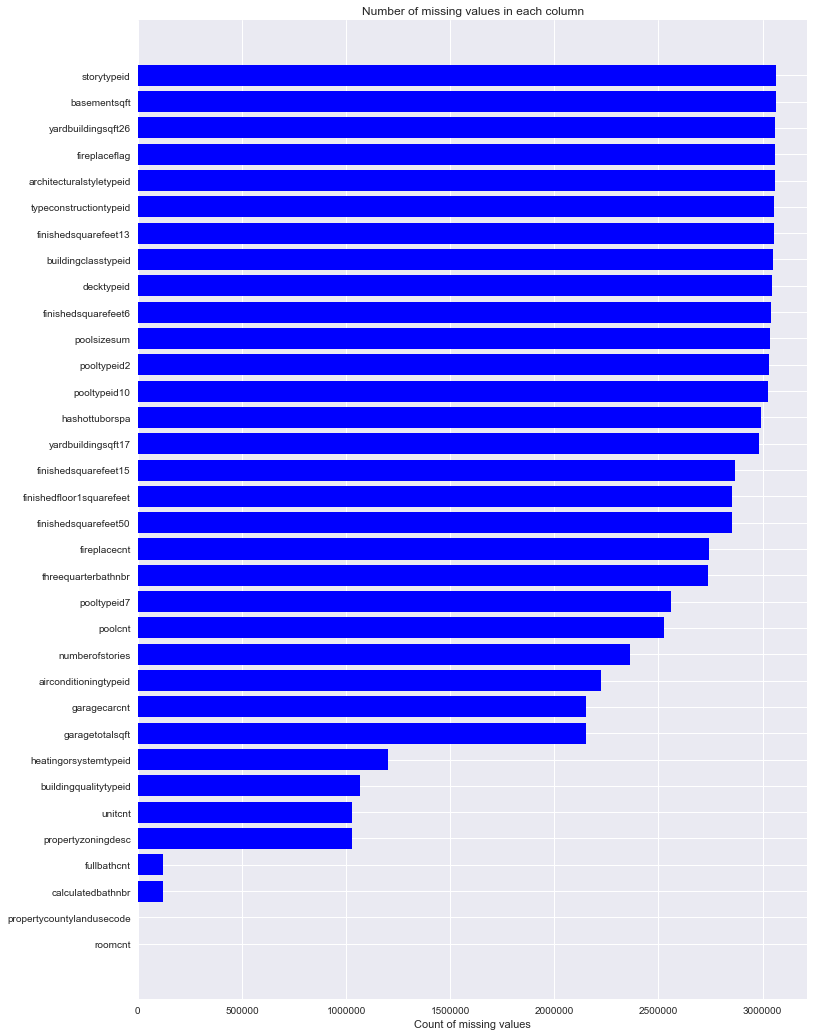

In [3]:
# Missing features
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

print missing_df['column_name'].count()

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

# Method Definition Mode

In [5]:
import numpy

def mode1(ndarray, axis=0):
    # Check inputs
    ndarray = numpy.asarray(ndarray)
    ndim = ndarray.ndim
    if ndarray.size == 1:
        return (ndarray[0], 1)
    elif ndarray.size == 0:
        raise Exception('Cannot compute mode on empty array')
    try:
        axis = range(ndarray.ndim)[axis]
    except:
        raise Exception('Axis "{}" incompatible with the {}-dimension array'.format(axis, ndim))

    # If array is 1-D and numpy version is > 1.9 numpy.unique will suffice
    if all([ndim == 1,
            int(numpy.__version__.split('.')[0]) >= 1,
            int(numpy.__version__.split('.')[1]) >= 9]):
        modals, counts = numpy.unique(ndarray, return_counts=True)
        index = numpy.argmax(counts)
        return modals[index], counts[index]

    # Sort array
    sort = numpy.sort(ndarray, axis=axis)
    # Create array to transpose along the axis and get padding shape
    transpose = numpy.roll(numpy.arange(ndim)[::-1], axis)
    shape = list(sort.shape)
    shape[axis] = 1
    # Create a boolean array along strides of unique values
    strides = numpy.concatenate([numpy.zeros(shape=shape, dtype='bool'),
                                 numpy.diff(sort, axis=axis) == 0,
                                 numpy.zeros(shape=shape, dtype='bool')],
                                axis=axis).transpose(transpose).ravel()
    # Count the stride lengths
    counts = numpy.cumsum(strides)
    counts[~strides] = numpy.concatenate([[0], numpy.diff(counts[~strides])])
    counts[strides] = 0
    # Get shape of padded counts and slice to return to the original shape
    shape = numpy.array(sort.shape)
    shape[axis] += 1
    shape = shape[transpose]
    slices = [slice(None)] * ndim
    slices[axis] = slice(1, None)
    # Reshape and compute final counts
    counts = counts.reshape(shape).transpose(transpose)[slices] + 1

    # Find maximum counts and return modals/counts
    slices = [slice(None, i) for i in sort.shape]
    del slices[axis]
    index = numpy.ogrid[slices]
    index.insert(axis, numpy.argmax(counts, axis=axis))
    return sort[index], counts[index]

# 1. Mean/ Mode

In [30]:
missing_features = list(missing_df["column_name"].values)
print missing_features
print("\n")

for feature in missing_features:
    f_type = df_feature_type["Type"][df_feature_type["Feature"]==feature].values[0]
    print feature,f_type
    print("Missing Count = %g" %missing_df["missing_count"][missing_df["column_name"]==feature])
    
    try:
        if f_type == 'cont':
            df[feature] = df[feature].fillna(df[feature].mean())
            print ("Successfully filled %s" %feature)
            print("\n")
        
        # Select one of two options below. Comment out the other one
        
        # Option 1 : Fill with mode
        if f_type == 'disc' or f_type == 'factor':
            f_mode, f_freq = mode1(df[feature].values)
            print f_mode
            df[feature] = df[feature].fillna(f_mode) 
            print ("Successfully filled %s" %feature)
            print("\n")
            
        # Option 2: Fill with mode for factors and with median for disc
        #if f_type == 'disc':
        #    df[feature] = df[feature].fillna(df[feature].median())
        #    print ("Successfully filled %s" %feature)            
        #if f_type == 'factor':
        #    f_mode, f_freq = mode(df[feature].values,nan_policy='omit')
        #    df[feature] = df[feature].fillna(f_mode) 
        #    print ("Successfully filled %s" %feature)        
        
    except:
        print("%s not filled" %feature)
        pass
    

['assessmentyear', 'bedroomcnt', 'bathroomcnt', 'roomcnt', 'propertycountylandusecode', 'taxamount', 'taxvaluedollarcnt', 'structuretaxvaluedollarcnt', 'calculatedfinishedsquarefeet', 'yearbuilt', 'landtaxvaluedollarcnt', 'calculatedbathnbr', 'fullbathcnt', 'finishedsquarefeet12', 'lotsizesquarefeet', 'propertyzoningdesc', 'unitcnt', 'buildingqualitytypeid', 'heatingorsystemtypeid', 'garagecarcnt', 'garagetotalsqft', 'airconditioningtypeid', 'numberofstories', 'poolcnt', 'pooltypeid7', 'threequarterbathnbr', 'fireplacecnt', 'finishedfloor1squarefeet', 'finishedsquarefeet50', 'finishedsquarefeet15', 'yardbuildingsqft17', 'hashottuborspa', 'pooltypeid10', 'pooltypeid2', 'poolsizesum', 'finishedsquarefeet6', 'decktypeid', 'buildingclasstypeid', 'finishedsquarefeet13', 'typeconstructiontypeid', 'architecturalstyletypeid', 'fireplaceflag', 'yardbuildingsqft26', 'basementsqft', 'storytypeid']


assessmentyear disc
Missing Count = 2
2015.0
Successfully filled assessmentyear


bedroomcnt disc


In [31]:
df.isnull().sum(axis=0)

parcelid                        0
logerror                        0
transactiondate                 0
airconditioningtypeid           0
architecturalstyletypeid        0
basementsqft                    0
bathroomcnt                     0
bedroomcnt                      0
buildingclasstypeid             0
buildingqualitytypeid           0
calculatedbathnbr               0
decktypeid                      0
finishedfloor1squarefeet        0
calculatedfinishedsquarefeet    0
finishedsquarefeet12            0
finishedsquarefeet13            0
finishedsquarefeet15            0
finishedsquarefeet50            0
finishedsquarefeet6             0
fips                            0
fireplacecnt                    0
fullbathcnt                     0
garagecarcnt                    0
garagetotalsqft                 0
hashottuborspa                  0
heatingorsystemtypeid           0
latitude                        0
longitude                       0
lotsizesquarefeet               0
poolcnt       

In [32]:
# Save the dataframe
df.to_pickle("df_train_filled_with_mean_mode.pkl")

# 2. KNN with top 15 features


Import feature importance df to use 15 most important features.

In [4]:
df_f_imp = pd.read_pickle("feature_importance.pkl")

In [51]:
df_f_imp

,index,Not Missing %,SUM
0,structuretaxvaluedollarcnt,98.00,102
1,yearbuilt,98.00,100
2,propertylandusetypeid,100.00,83
3,lotsizesquarefeet,91.00,82
4,calculatedfinishedsquarefeet,98.00,80
5,taxamount,99.00,77
6,finishedsquarefeet12,91.00,72
7,regionidcity,100.00,64
8,landtaxvaluedollarcnt,98.00,63
9,latitude,100.00,53


## Using KDTree to find nearest neighbors

### Fill the first 15 

### Type 1: Each feature has its own tree based on features with 100% data 

### Vectorized form

In [52]:
class knn(object):
    
    def __init__(self,feature,tree):
        self.feature = feature
        self.tree = tree

    def fill(self,X,df,k):
        # f refers to feature
        f_type = df_feature_type["Type"][df_feature_type["Feature"]==self.feature].values[0]
        print("Missing Count = %g" %missing_df["missing_count"][missing_df["column_name"]==self.feature])
        dist,ind = self.tree.query(X,k=k)
        [m,n] = ind.shape
        f_value = lambda t: df[self.feature].iloc[t]
        map_f = np.vectorize(f_value)
        f_matrix = map_f(ind)
        
        if  f_type == 'cont':
            f_value = np.nanmean(f_matrix,axis = 1)
        
        if f_type == 'disc' or f_type == 'factor':
            f_value, f_freq = mode1(f_matrix,axis=1)

        return f_value


In [53]:
# create top 15 features dataframe in order of filled data (non missing data)
df_f_tmp2 = df_f_imp[0:15].sort_values(by="Not Missing %", ascending=False)
top_15_f = list(df_f_tmp2["index"].values) 
df_top_15 = df[top_15_f]

counter = 0

for feature in top_15_f:

        if df_f_tmp2["Not Missing %"][df_f_tmp2["index"]==feature].values[0] != 100.:
            
            print("Starting feature: %s" %feature)    
    
            # time the execution
            t1 = time.time()

            # create dataframe with features with 100% filled data
            # Everytime a feature is completed, the training data is updated
            full_f = list(df_f_imp["index"][df_f_imp["Not Missing %"]==100.].values) 
            df_full = df[full_f]

            # create training df and df_to_be_filled
            tmp_df1 = df_full.copy() 
            tmp_df1[feature] = df_top_15[feature]    # add feature column to df_full
            tmp_df2 = tmp_df1.dropna().reset_index()
            tmp_df3 = tmp_df2.drop([feature,"index"],1)
            df_to_be_filled = tmp_df1[tmp_df1[feature].isnull()] 
            [m,n]  = df_to_be_filled.shape
            training_df = tmp_df3.as_matrix()

            # start building tree
            t2 = time.time()
            print('Creating KDTree')
            tree = KDTree(training_df)
            # end tree
            t3 = time.time()
            print("Tree Build Time: %g" %(t3-t2))

            k = 50

            # fill the missing element
            X = df_to_be_filled[full_f].as_matrix()
            #X = np.reshape(X,(1,-1))
            f_knn = knn(feature,tree)
            df_to_be_filled[feature] = f_knn.fill(X,tmp_df2,k)

            # finish execution
            t4 = time.time()
            print("Exec time: %g" %(t4-t1))

            df_top_15.update(df_to_be_filled,join='left')
            df.update(df_to_be_filled,join='left')
            print("saving after completing %s" %feature)
            df_top_15.to_pickle("df.pkl")

            # update the feature importance dataframe
            if df_top_15[feature].isnull().sum() == 0:
                df_f_tmp2["Not Missing %"][df_f_tmp2["index"]==feature] = 100.
                df_f_imp["Not Missing %"][df_f_imp["index"]==feature] = 100.
            else:
                not_filled = df_top_15[feature].isnull().sum()
                print("Feature %s not completed. %g not filled" %(feature,not_filled))

            print("Finished feature %s" %feature)
            print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~**********************~~~~~~~~~~~~~~~~~~~~~~~~~~~~~*******************")
            
        else:
            print("Already complete: %s " %feature)  
            
        counter += 1    

Already complete: propertylandusetypeid 
Already complete: regionidcity 
Already complete: latitude 
Already complete: longitude 
Already complete: rawcensustractandblock 
Starting feature: bedroomcnt
Creating KDTree
Tree Build Time: 16.808
Missing Count = 13


C:\Users\Lakshay\Anaconda2\lib\site-packages\ipykernel\__main__.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Exec time: 18.625


C:\Users\Lakshay\Anaconda2\lib\site-packages\pandas\core\frame.py:3765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  raise_on_error=True)


saving after completing bedroomcnt


C:\Users\Lakshay\Anaconda2\lib\site-packages\ipykernel\__main__.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Lakshay\Anaconda2\lib\site-packages\ipykernel\__main__.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Finished feature bedroomcnt
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~**********************~~~~~~~~~~~~~~~~~~~~~~~~~~~~~*******************
Starting feature: bathroomcnt
Creating KDTree
Tree Build Time: 16.872
Missing Count = 25
Exec time: 18.804
saving after completing bathroomcnt
Finished feature bathroomcnt
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~**********************~~~~~~~~~~~~~~~~~~~~~~~~~~~~~*******************
Starting feature: taxamount
Creating KDTree
Tree Build Time: 17.747
Missing Count = 19819
Exec time: 35.366
saving after completing taxamount
Finished feature taxamount
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~**********************~~~~~~~~~~~~~~~~~~~~~~~~~~~~~*******************
Starting feature: taxvaluedollarcnt
Creating KDTree
Tree Build Time: 19.697
Missing Count = 31114
Exec time: 45.962
saving after completing taxvaluedollarcnt
Finished feature taxvaluedollarcnt
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~**********************~~~~~~~~~~~~~~~~~~~~~~~~~~~~~*******************
Starting feature: stru

In [55]:
df.to_pickle("df_w_top_15_filled.pkl")

parcelid


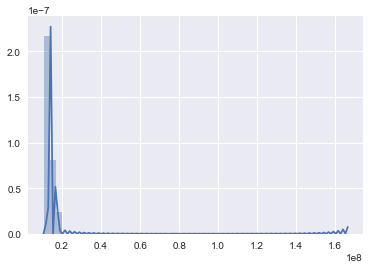

logerror


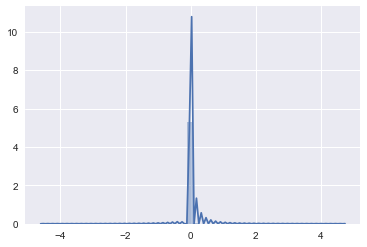

transactiondate
airconditioningtypeid
architecturalstyletypeid
basementsqft
bathroomcnt


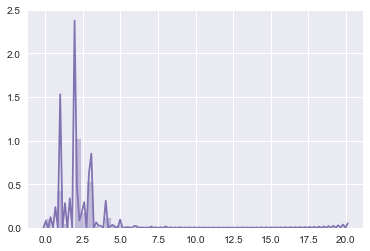

bedroomcnt


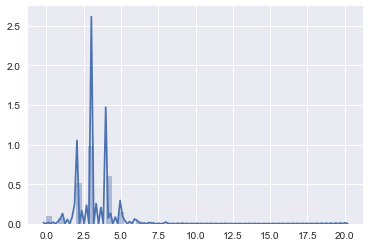

buildingclasstypeid
buildingqualitytypeid
calculatedbathnbr
decktypeid
finishedfloor1squarefeet
calculatedfinishedsquarefeet


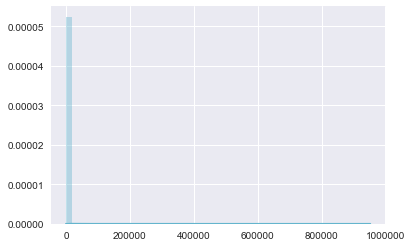

finishedsquarefeet12


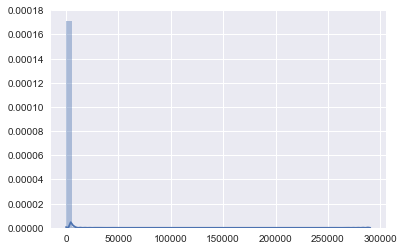

finishedsquarefeet13
finishedsquarefeet15
finishedsquarefeet50
finishedsquarefeet6
fips


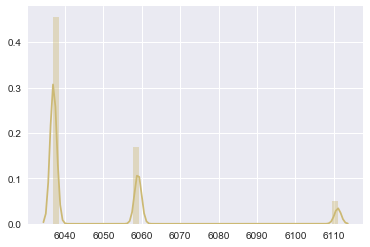

fireplacecnt
fullbathcnt
garagecarcnt
garagetotalsqft
hashottuborspa
heatingorsystemtypeid
latitude


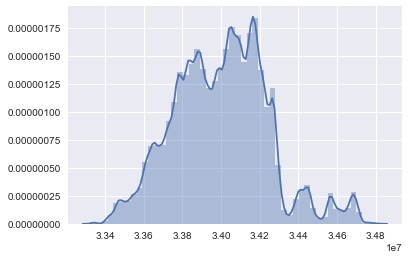

longitude


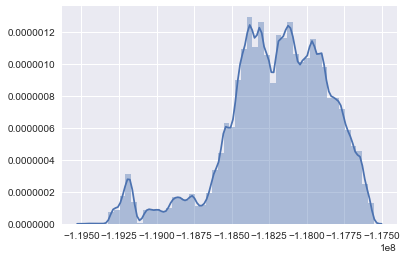

lotsizesquarefeet


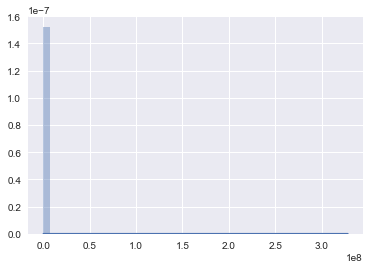

poolcnt
poolsizesum
pooltypeid10
pooltypeid2
pooltypeid7


In [ ]:
# Check the distribution of filled data
for f in df.columns.tolist():
    try:
        print f
        sns.distplot(df[f].values)
        plt.show()
    except:
        pass

In [ ]:
# Load dataframe filled using mean-mode method
df_mean_style = pd.read_pickle("df_train_filled_with_mean_mode.pkl")

In [ ]:
# compare the two methods
f_list = top_15_f[6:]

for f in f_list:
    print f
    x = df[f].values
    y = df_mean_style[f].values
    dev = np.absolute(x-y)
    num = np.linspace(0,len(dev),len(dev))
    plt.scatter(num,dev,s=2)
    #plt.hist([x, y],color=['r','b'], alpha=0.5)
    plt.show()
    

It is evident is from the above plots, the difference of managing data from both the methods is quite significant. Results should vary too

# Filling Rest of the data

### Rest of the data is filled using KNN with the features with 100% data (which includes the 15 filled above) 

In [65]:
na_perct = df.isnull().sum().values/(n_rows*1.0)
df_na_summary = pd.DataFrame(df.columns.tolist(),columns=["Feature"])
df_na_summary["% NA"] = na_perct
df_na_summary["feature_type"] = df_feature_type["Type"].values

In [39]:

class knn_2(object):
    
    def __init__(self,feature,tree,df_na_summary):
        self.feature = feature
        self.tree = tree
        self.df_na_summary = df_na_summary

    def fill(self,X,df,k):
        # f refers to feature
        
        f_type = df_feature_type["Type"][df_feature_type["Feature"]==self.feature].values[0]
        print("Missing Count = %g" %missing_df["missing_count"][missing_df["column_name"]==self.feature])
       
        print("Function evaluation started")
        dist,ind = self.tree.query(X,k=k)
        [m,n] = ind.shape
        f_value = lambda t: df[self.feature].iloc[t]
        #map_f = np.vectorize(f_value)
        b_tmp = np.reshape(ind,(m*n,))
        tt1 = time.time()
        results = map(f_value,b_tmp)
        print("training_time: %g" %(time.time()-tt1))
        f_matrix = np.reshape(results,(m,n))
        print f_matrix.shape
        
        if f_type == 'cont':
            feature_m = np.nanmean(f_matrix,axis = 1)
     
        if f_type == 'disc':
            feature_m, feature_freq = mode1(f_matrix,axis=1)
            
        if f_type == 'factor':
            if f_matrix.dtype != 'float64' or f_matrix.dtype != 'float32' or f_matrix.dtype != 'int':
                feature_m, feature_freq = mode(f_matrix,axis=1)
                feature_m = np.ndarray.flatten(feature_m)
             
            else:
                feature_m, feature_freq = mode1(f_matrix,axis=1)
                    
        return feature_m


In [73]:
# create top 15 features dataframe in order of filled data (non missing data)
threshold = 0.9
less_than_threshold = df_na_summary["Feature"][df_na_summary["% NA"] < threshold].values
filled = df_na_summary["Feature"][df_na_summary["% NA"] == 0.].values
to_be_filled = [x for x in less_than_threshold if x not in filled ]
full_features = df_na_summary["Feature"][df_na_summary["% NA"] == 0.0 ].values
to_remove = ["parcelid","logerror","transactiondate","taxdelinquencyflag"]
full_features = [x for x in full_features if x not in to_remove]
#full_features = np.asarray(full_features)

df_not_full_f = df[to_be_filled] # dataframe with features with incomplete data
df_full_features = df[full_features]
counter = 0

for feature in to_be_filled:
        
        local_feature_space = full_features + [feature]
        
        print("Starting feature: %s" %feature)    

        # time the execution
        t1 = time.time()

        # create training df and df_to_be_filled
        tmp_df1 = df[local_feature_space]
        tmp_df2 = tmp_df1[tmp_df1[feature].notnull()]
        df_to_be_filled_2 = tmp_df1[tmp_df1[feature].isnull()]
        #training_df = tmp_df2[full_features]
        training_df = tmp_df2[top_15_f]
        
        # start building tree
        t2 = time.time()
        print('Creating KDTree')
        tree = KDTree(training_df)
        # end tree
        t3 = time.time()
        print("Tree Build Time: %g" %(t3-t2))

        k = 50
        
        # fill the missing element
        #X = df_to_be_filled_2[full_features].as_matrix()
        X = df_to_be_filled_2[top_15_f].as_matrix()
        f_knn_2 = knn_2(feature,tree,df_na_summary)
        df_to_be_filled_2[feature] = f_knn_2.fill(X,tmp_df2,k)

        # finish execution
        t4 = time.time()
        print("Exec time: %g" %(t4-t1))

        df.update(df_to_be_filled_2,join='left')
        print("saving after completing %s" %feature)
        df_to_be_filled_2.to_pickle("df_to_be_filled_v2_" + feature + ".pkl")
        df.to_pickle("full_df_v2_" + feature + ".pkl")
        
        print("Finished feature %s" %feature)
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~**********************~~~~~~~~~~~~~~~~~~~~~~~~~~~~~*******************")

        counter += 1  



Starting feature: propertyzoningdesc
Creating KDTree
Tree Build Time: 15.38
Missing Count = 1.02711e+06
Function evaluation started
training_time: 809.488
(1027113L, 50L)
[['LCR19000*' 'LCR19000*' 'LCR19000*' ..., 'LCR120000*' 'LCR19000*'
  'LCR19000*']
 ['LBPD1' 'LBPD1' 'LBPD1' ..., 'LBR1N' 'LBPD1' 'LBPD1']
 ['LCRA1*' 'LCA11*' 'LCA11*' ..., 'WVRPD18U*' 'WVRPD18U*' 'WVRPD18U*']
 ..., 
 ['LCR19000*' 'LCR19000*' 'LCR19000*' ..., 'LCR171/2' 'LCR17500*'
  'LCCPD-RPD1']
 ['LCR19000*' 'LCR19000*' 'LCR17500*' ..., 'LCR17500*' 'LCA11Y' 'LCR19000*']
 ['LMR110000*' 'LMR110000*' 'LMR110000*' ..., 'LMRI' 'LMR110000*' 'LMPUD*']]


C:\Users\Lakshay\Anaconda2\lib\site-packages\ipykernel\__main__.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Exec time: 2980.36
saving after completing propertyzoningdesc
Finished feature propertyzoningdesc
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~**********************~~~~~~~~~~~~~~~~~~~~~~~~~~~~~*******************
Starting feature: roomcnt
Creating KDTree
Tree Build Time: 27.772
Missing Count = 38
Function evaluation started
training_time: 0.03
(38L, 50L)
Exec time: 29.504
saving after completing roomcnt
Finished feature roomcnt
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~**********************~~~~~~~~~~~~~~~~~~~~~~~~~~~~~*******************
Starting feature: threequarterbathnbr
Creating KDTree
Tree Build Time: 0.931
Missing Count = 2.74042e+06
Function evaluation started
training_time: 2181.83
(2740415L, 50L)
Exec time: 3769.56
saving after completing threequarterbathnbr
Finished feature threequarterbathnbr
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~**********************~~~~~~~~~~~~~~~~~~~~~~~~~~~~~*******************
Starting feature: unitcnt
Creating KDTree
Tree Build Time: 16.008
Missing Count = 1.02821e+06
Funct

parcelid                              0
logerror                              0
transactiondate                       0
airconditioningtypeid                 0
architecturalstyletypeid        3057733
basementsqft                    3062384
bathroomcnt                           0
bedroomcnt                            0
buildingclasstypeid             3051410
buildingqualitytypeid                 0
calculatedbathnbr                     0
decktypeid                      3046301
finishedfloor1squarefeet        2854482
calculatedfinishedsquarefeet          0
finishedsquarefeet12                  0
finishedsquarefeet13            3056350
finishedsquarefeet15            2869693
finishedsquarefeet50            2854482
finishedsquarefeet6             3041633
fips                                  0
fireplacecnt                          0
fullbathcnt                           0
garagecarcnt                          0
garagetotalsqft                       0
hashottuborspa                  2992676
